<h2>Linear regression</h2>

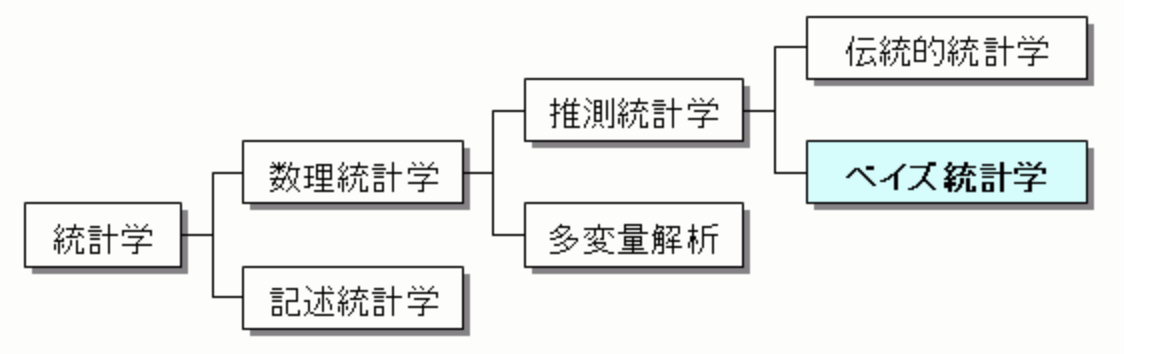

In [20]:
Image('Bayes.png')

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3 import *

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [17]:
from IPython.display import Image

頻度主義者の一般化線形モデル

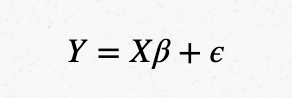

In [18]:
Image('GLM_Frequentist.png')

ベイズ主義者の一般化線形モデル（↑をベイズ変換）

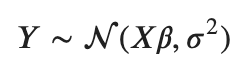

In [19]:
Image('GLM_Bayesian.png')

ベイズ化するメリット

<ul>
    <li>事前知識：パラメータに事前知識を配置することで、事前知識を定量化できる。たとえば、𝜎が小さい可能性が高いと思われる場合は、低い値でより多くの確率質量を持つ事前確率を選択する。</li>
    <li>不確実性の定量化：上記のように𝛽の単一の推定値を取得するのではなく、𝛽の異なる値がどの程度ありそうかについての完全な事後分布を取得する。たとえば、データポイントが少ないと、𝛽の不確実性が非常に高くなり、非常に幅広い事後確率が得られる。</li>
</ul>

<h3>データの生成</h3>

In [5]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# ノイズを加える
y = true_regression_line + np.random.normal(scale=0.5, size=size)

data = dict(x=x, y=y)

In [6]:
data

{'x': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
        0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
        0.35175879, 0.35678392, 0.36180905,

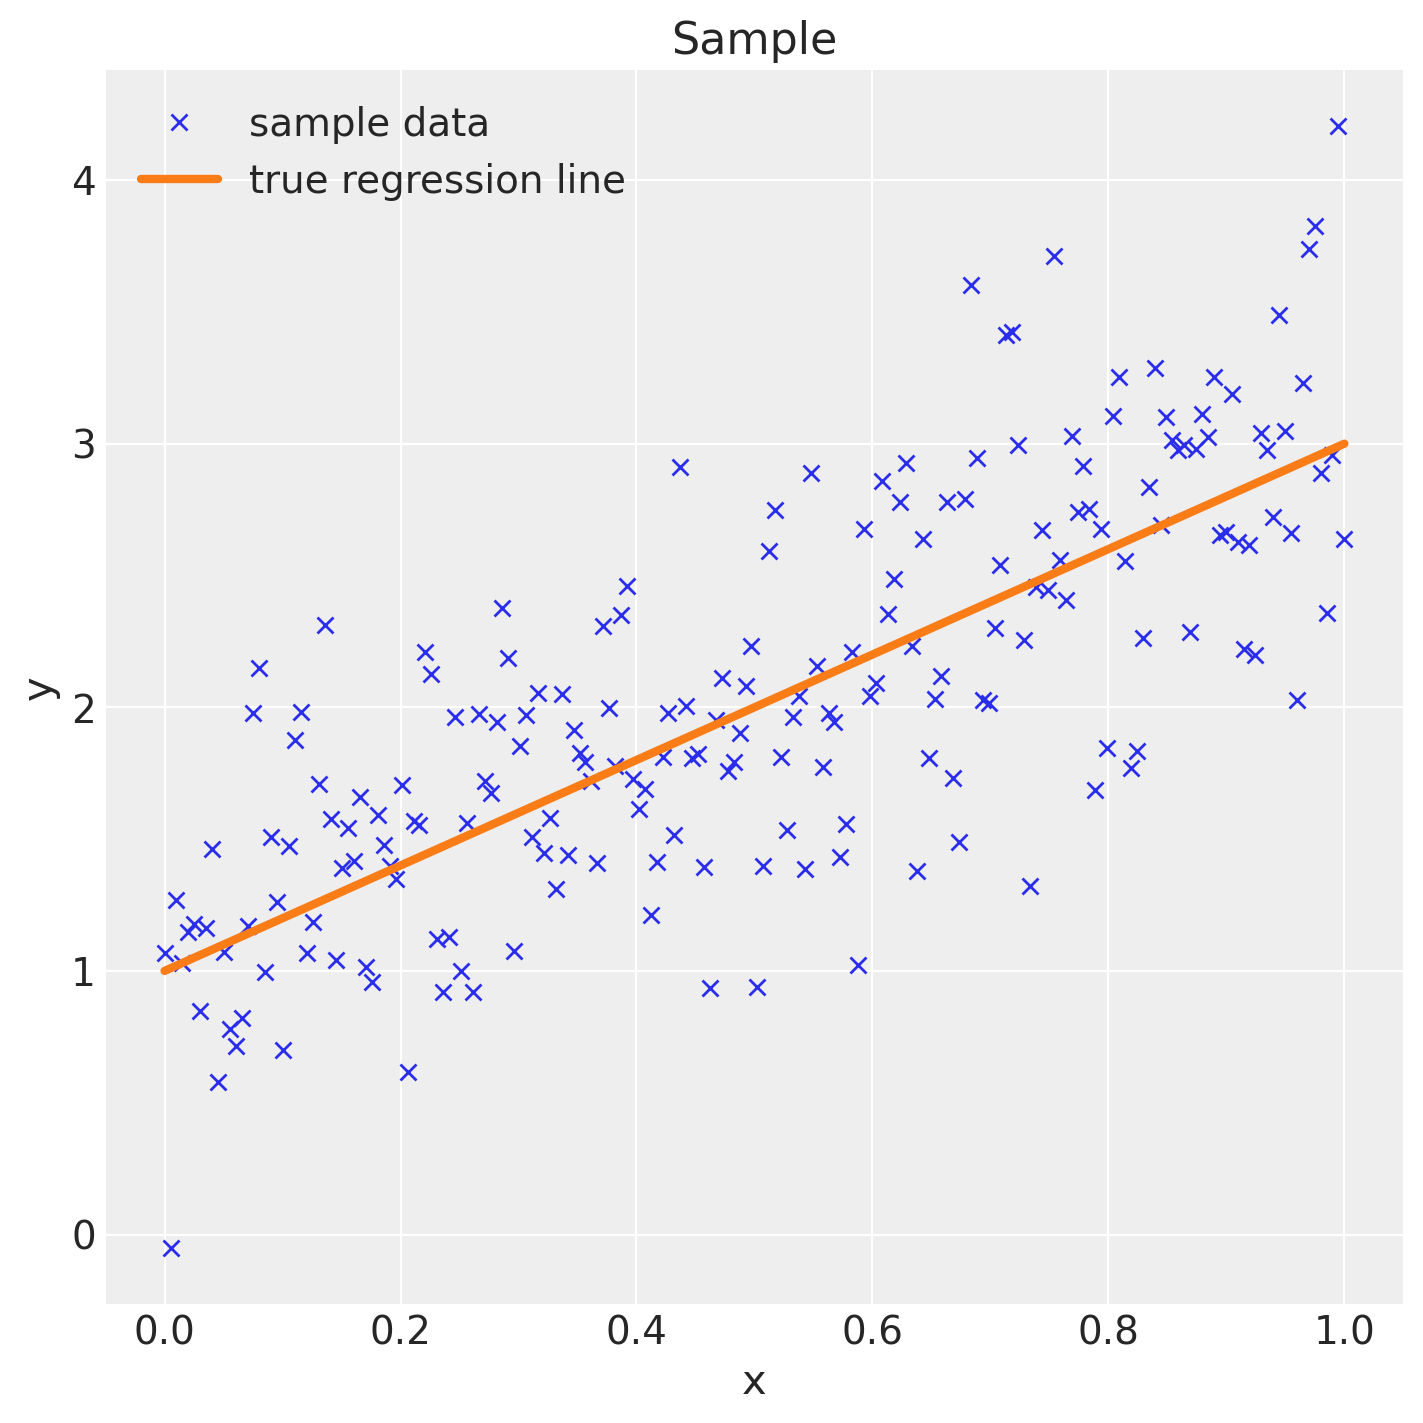

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Sample")
ax.plot(x, y, "x", label="sample data")
ax.plot(x, true_regression_line, label="true regression line", lw=3.0)
plt.legend(loc=0)

<h3>モデルの生成</h3>

〜力ずくver.〜

In [9]:
with pm.Model() as model:
    # 事前分布の設定（パラメータの範囲を設定する = 正則化しているとみなすことが可能）
    ## 半コーシー分布（正規分布の分散）
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    ## 切片（正規分布）
    intercept = pm.Normal("Intercept", 0, sigma=20)
    ## 回帰係数（正規分布）
    x_coeff = pm.Normal("x", 0, sigma=20)
    
    # 尤度を定義
    likelihood = Normal("y", mu=intercept+x_coeff*x, sigma=sigma, observed=y)
    
    # 推論（MCMC実行）
    trace = pm.sample(3000, cores=2)

/Users/kohei/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 14 seconds.


PyMC3を使って一行でモデルを生成する

In [10]:
with pm.Model() as model:
    # 上記と同様のモデルを一行で生成可能
    # データを渡すことで、モデルを生成してくれる
    pm.glm.GLM.from_formula("y ~ x", data)
    
    # 推論（MCMC実行）
    trace = pm.sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling

/Users/kohei/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 11 seconds.


<h3>モデルの評価</h3>

/Users/kohei/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

<Figure size 700x700 with 0 Axes>

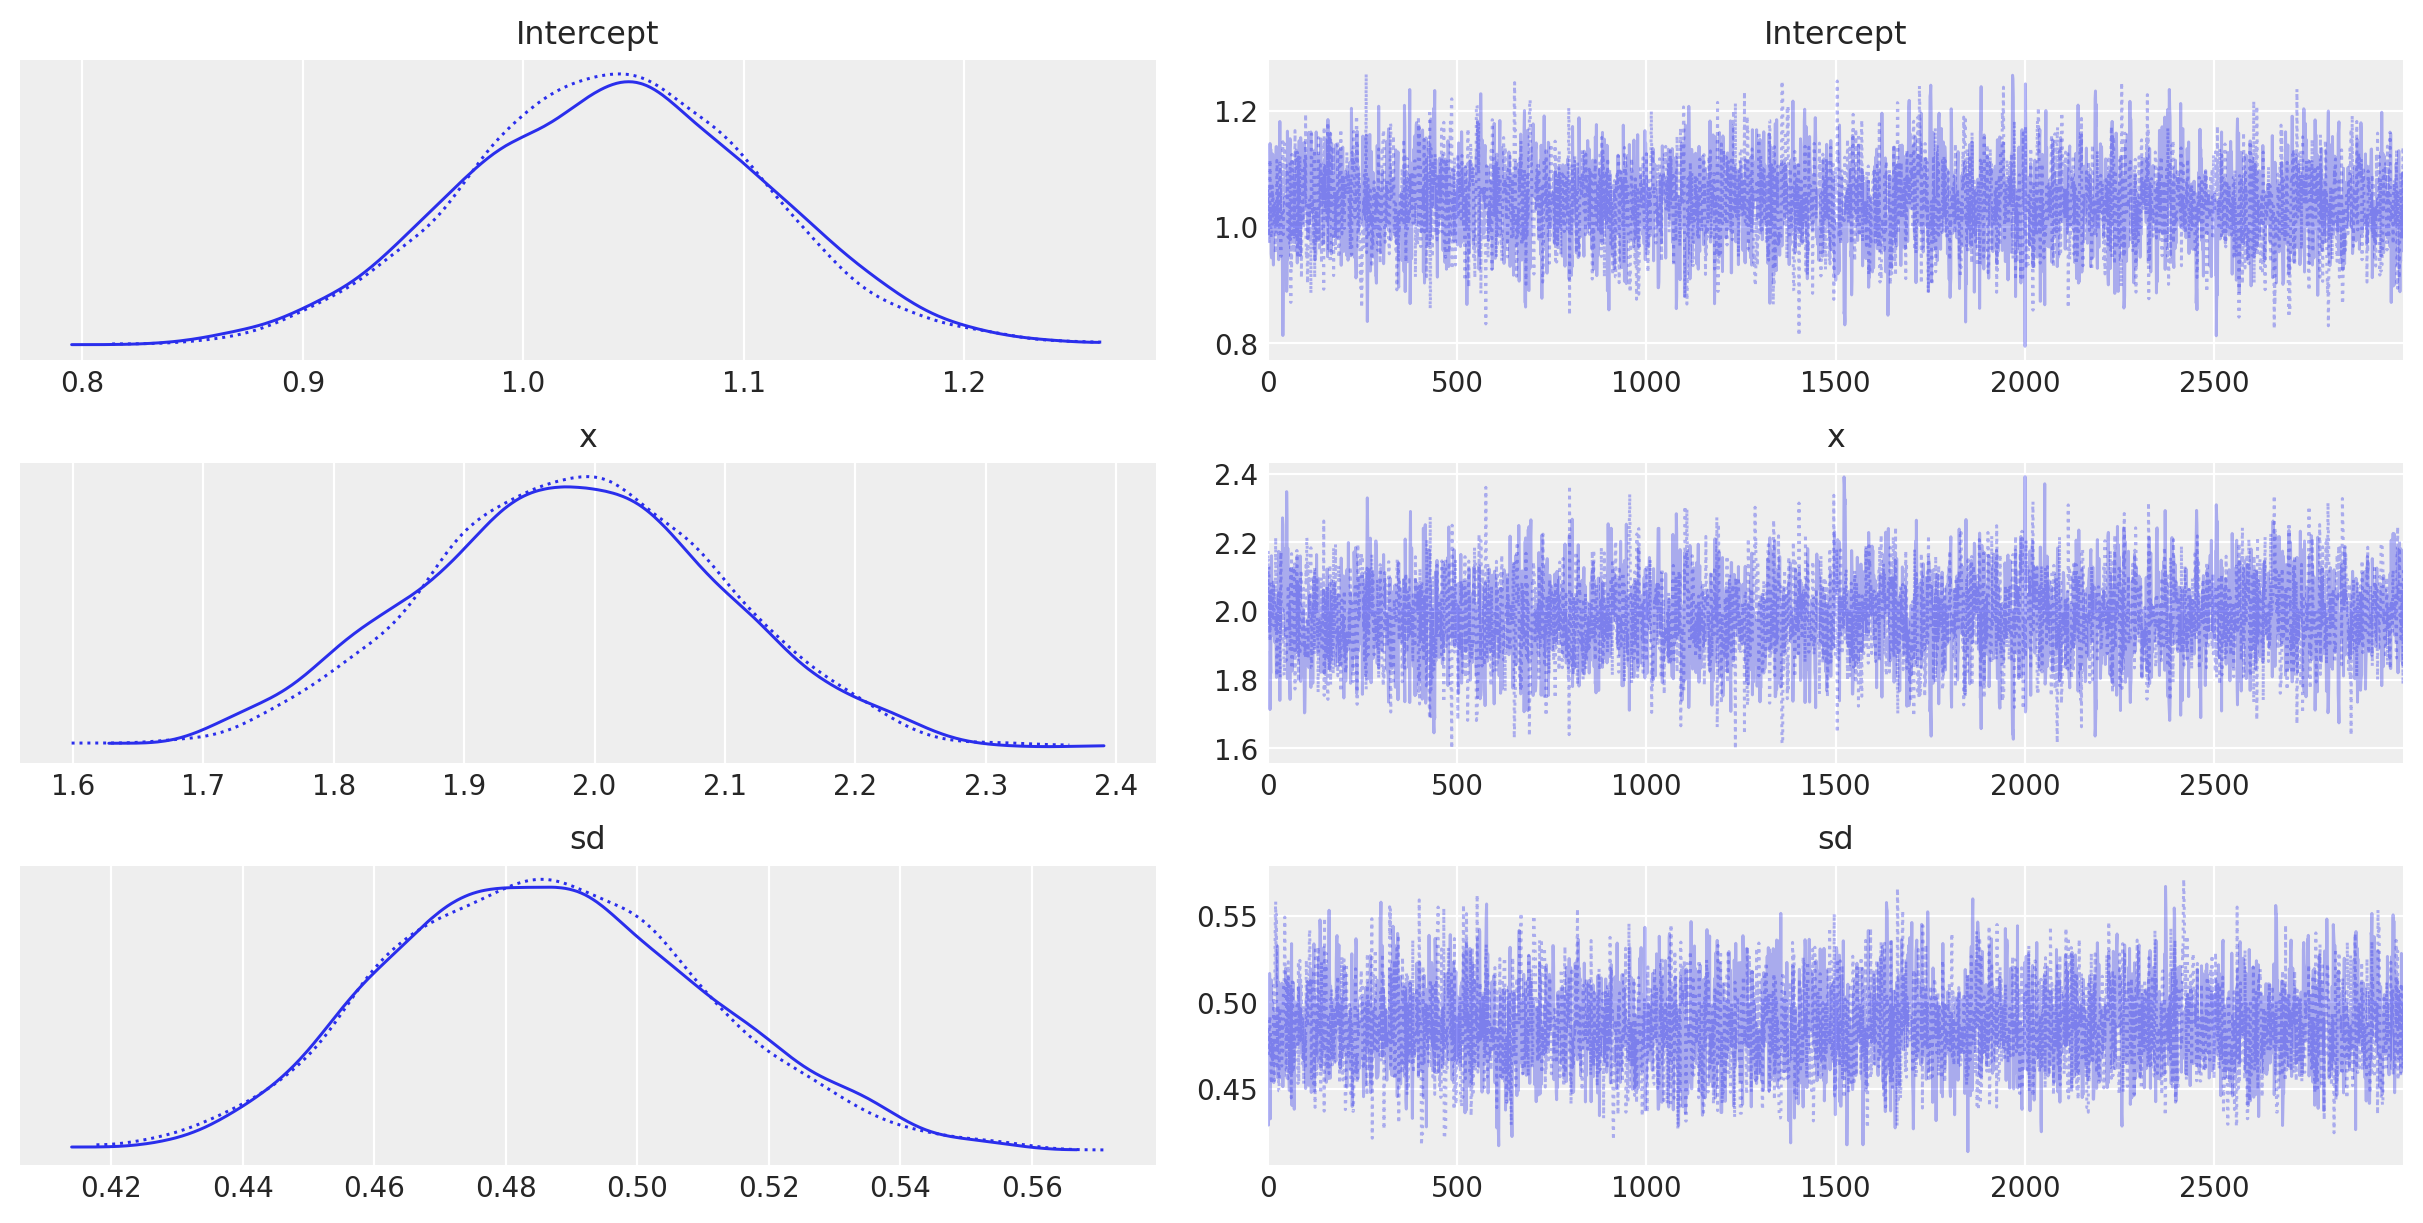

In [11]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)

/Users/kohei/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'x'}>,
       <AxesSubplot:title={'center':'sd'}>], dtype=object)

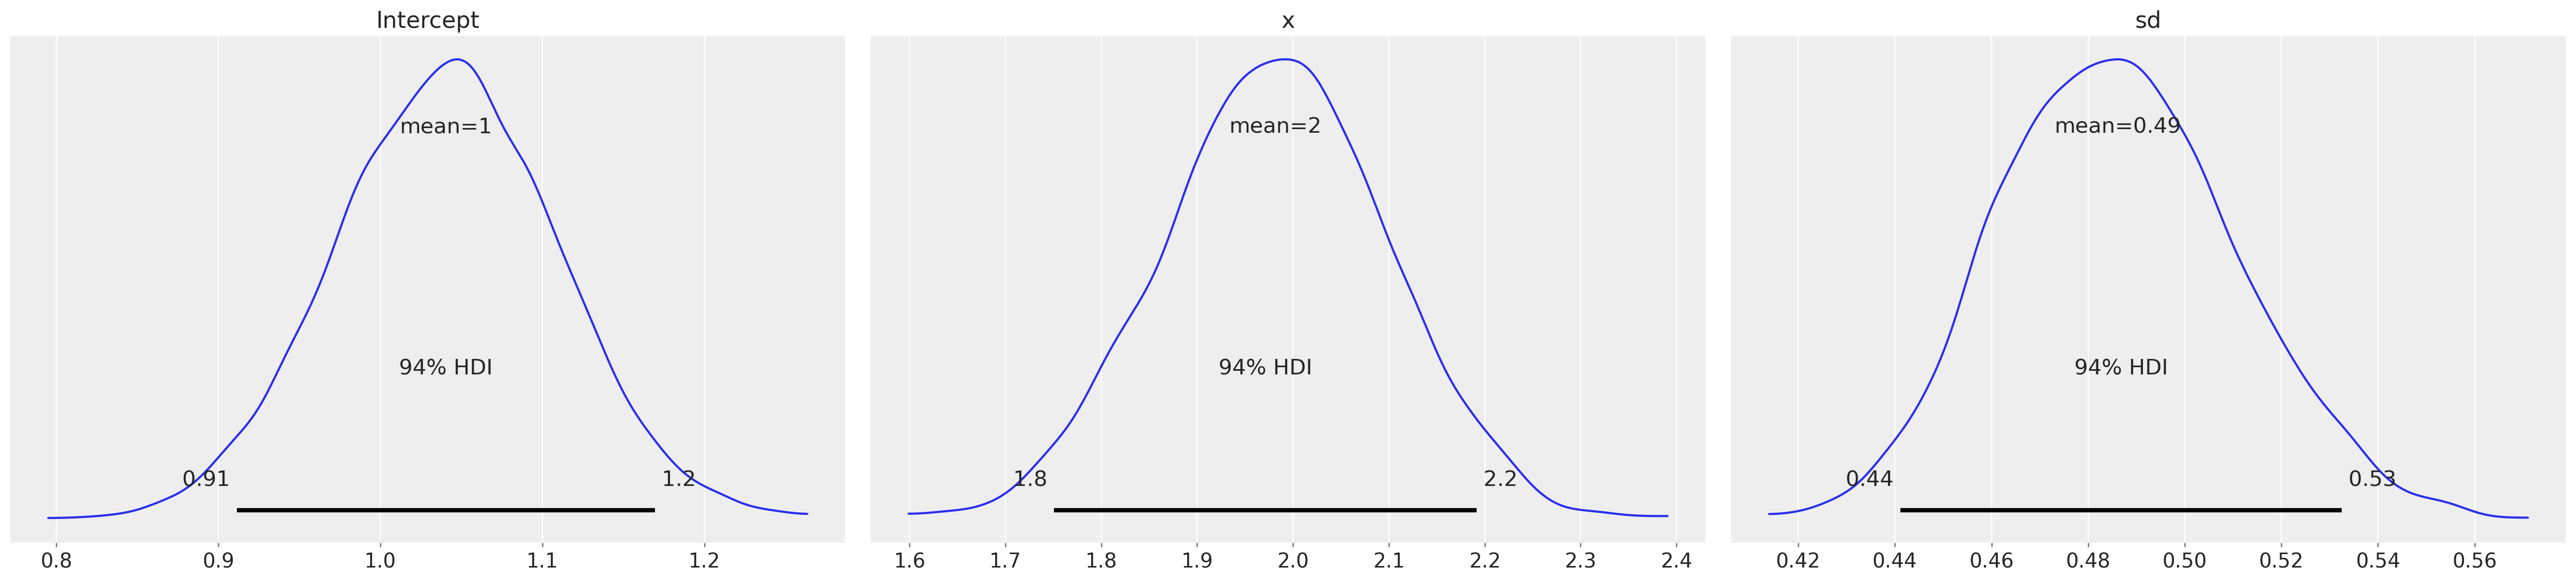

In [12]:
pm.plot_posterior(trace)

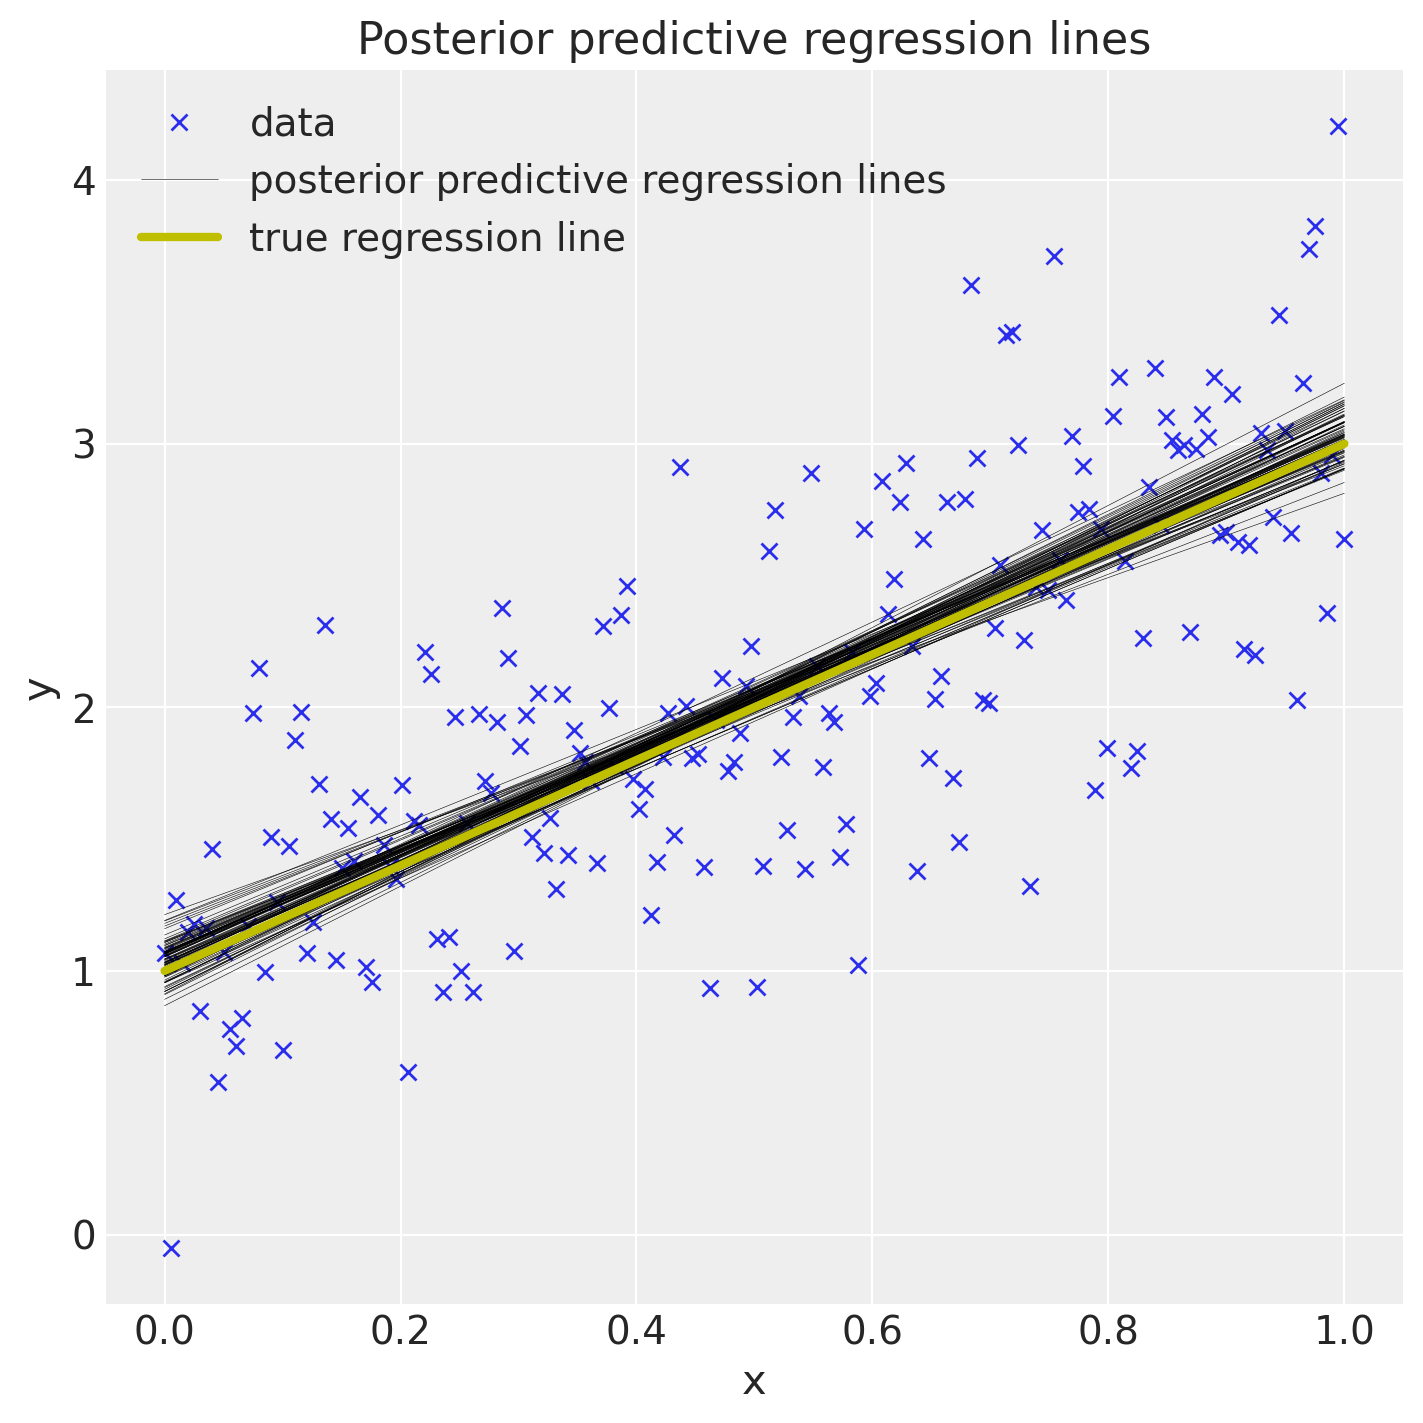

In [16]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "x", label="data")
pm.plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

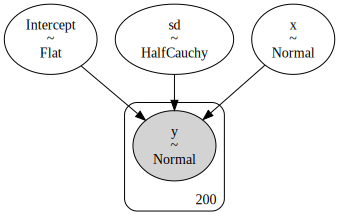

In [14]:
pm.model_to_graphviz(model)